# Lens Modeling for DESIJ0201-2739

##### Author(s): S M Rafee Adnan, Anowar J. Shajib
##### Acknowledgement: Nusrath Jahan, Jobair Hasan

In [2]:
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np

import corner

from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

## Loading Data from h5 Files

In [3]:
with h5py.File("./DESIJ0201-2739_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

{'background_rms': 0.01404157127982487,
 'dec_at_xy_0': -3.7999999999999963,
 'exposure_time': array([[468.09467, 395.12955, 415.5737 , ..., 383.2321 , 307.3302 ,
         391.50305],
        [478.88086, 458.88464, 528.76044, ..., 400.44812, 352.5698 ,
         475.39142],
        [502.22556, 478.23196, 411.78372, ..., 414.30704, 365.7324 ,
         408.81674],
        ...,
        [384.14526, 478.35782, 474.95016, ..., 352.72366, 309.66217,
         418.19092],
        [507.70087, 500.9363 , 468.81772, ..., 469.53363, 304.37845,
         188.47989],
        [444.80408, 379.014  , 479.2672 , ..., 199.31824, 295.39896,
         257.50208]], dtype=float32),
 'image_data': array([[ 7.64259999e-04,  1.43579504e-02,  6.96864084e-03, ...,
          1.72122439e-02,  3.27450470e-02,  5.61874645e-02],
        [ 2.48529123e-02,  1.60295657e-02,  6.32442589e-03, ...,
          1.92138441e-02,  6.23870750e-03,  2.18561702e-02],
        [-1.36858262e-02, -1.78021645e-02,  1.03761716e-02, ...,
     

In [4]:
with h5py.File("./psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"

kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

## Loading Imaging Data

<ipython-input-7-8dfdefc96695>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');


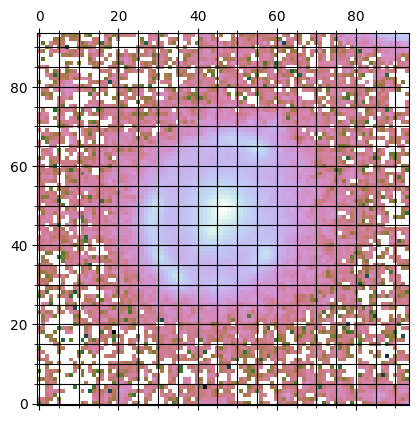

In [7]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

## Creating Mask

[[ 3.8   3.72  3.64 ... -3.48 -3.56 -3.64]
 [ 3.8   3.72  3.64 ... -3.48 -3.56 -3.64]
 [ 3.8   3.72  3.64 ... -3.48 -3.56 -3.64]
 ...
 [ 3.8   3.72  3.64 ... -3.48 -3.56 -3.64]
 [ 3.8   3.72  3.64 ... -3.48 -3.56 -3.64]
 [ 3.8   3.72  3.64 ... -3.48 -3.56 -3.64]] [[-3.8  -3.8  -3.8  ... -3.8  -3.8  -3.8 ]
 [-3.72 -3.72 -3.72 ... -3.72 -3.72 -3.72]
 [-3.64 -3.64 -3.64 ... -3.64 -3.64 -3.64]
 ...
 [ 3.48  3.48  3.48 ...  3.48  3.48  3.48]
 [ 3.56  3.56  3.56 ...  3.56  3.56  3.56]
 [ 3.64  3.64  3.64 ...  3.64  3.64  3.64]]


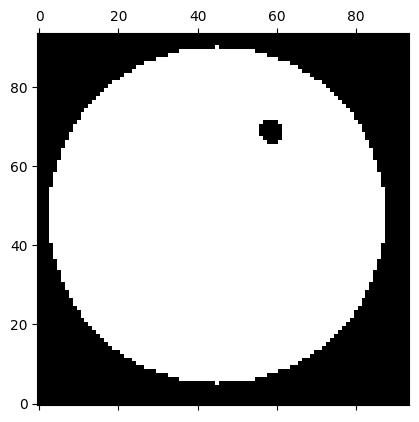

<ipython-input-8-f90f4d9bc37f>:52: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data'])*mask,


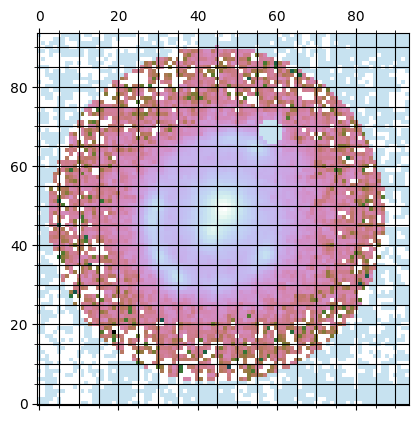

In [8]:
# To make a likelihood mask using lenstronomy functions,
# here is an example code:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

print(x_coords, y_coords)

r = 3.4  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra + 0.2,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.9,
    lens_center_dec + 1.7,
    0.25,
    0.25,
    0,
)


mask = (1 - mask_outer) * (1 - mask_ext_2)

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# mask image data

plt.matshow(
    np.log10(kwargs_data["image_data"]) * mask, origin="lower", cmap="cubehelix"
)
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

## Lens Modeling with Lenstronomy

In [9]:
lens_model_list = ["EPL", "SHEAR", "SIE"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

## Lens Galaxy's Mass Model

### EPL Parameters

In [10]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.1135,
        "gamma": 2.6746,
        "e1": 0.3281,
        "e2": 0.1449,
        "center_x": 0.1094,
        "center_y": -0.0316,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.1,
        "gamma": 1.2,
        "e1": -0.5,
        "e2": -1.2,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

### Shear Parameters

In [11]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append({"gamma1": -0.0316, "gamma2": -0.1530})
kwargs_lens_sigma.append({"gamma1": 0.01, "gamma2": 0.01})
kwargs_lower_lens.append({"gamma1": -0.5, "gamma2": -0.5})
kwargs_upper_lens.append({"gamma1": 0.4, "gamma2": 0.4})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

### SIE Parameters

In [12]:
satellite_center_x = +0.35
satellite_center_y = -0.40
satellite_centroid_bound = 0.3

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 0.4198,
        "e1": 0.3281,
        "e2": 0.1449,
        "center_x": satellite_center_x,
        "center_y": satellite_center_y,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_center_x / 4,
        "center_y": satellite_center_y / 4,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.0001,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": satellite_center_x - satellite_centroid_bound,
        "center_y": satellite_center_y - satellite_centroid_bound,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 2.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": satellite_center_x + satellite_centroid_bound,
        "center_y": satellite_center_y + satellite_centroid_bound,
    }
)

## Source Galaxy's Light Model

### Sersic Ellipse Parameters

In [13]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.0293,
        "n_sersic": 1,
        "e1": 0.3707,
        "e2": -0.6865,
        "center_x": 0.2227,
        "center_y": 0.1119,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.001,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 1,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -1.2,
        "R_sersic": 0.0001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.2,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### Shapelets Parameters

In [14]:
fixed_source.append({"n_max": 8})
kwargs_source_init.append({"center_x": 0.2227, "center_y": 0.1119, "beta": 0.1074})

kwargs_source_sigma.append({"center_x": 0.2, "center_y": 0.2, "beta": 0.001})

kwargs_lower_source.append({"center_x": -10, "center_y": -10, "beta": 0.001})

kwargs_upper_source.append({"center_x": 10, "center_y": 10, "beta": 0.18})

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]

## Lens Galaxy's Light Model

### 1st Sersic Ellipse Parameters

In [15]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.1267,
        "n_sersic": 2,
        "e1": -0.0988,
        "e2": -0.0680,
        "center_x": 0.0596,
        "center_y": 0.1341,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### 2nd Sersic Ellipse Parameters

In [16]:
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.9308,
        "n_sersic": 2,
        "e1": 0.0365,
        "e2": 0.0136,
        "center_x": 0.0596,
        "center_y": 0.1341,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.8,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### 3rd Sersic Sersic Ellipse Parameters

In [17]:
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.2805,
        "n_sersic": 2,
        "e1": 0.0447,
        "e2": -0.0950,
        "center_x": satellite_center_x,
        "center_y": satellite_center_y,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_centroid_bound / 4,
        "center_y": satellite_centroid_bound / 4,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": satellite_center_x - satellite_centroid_bound,
        "center_y": satellite_center_y - satellite_centroid_bound,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": satellite_center_x + satellite_centroid_bound,
        "center_y": satellite_center_y + satellite_centroid_bound,
        "amp": 100,
    }
)

In [18]:
joint_lens_with_lens_light = [[2, 2, ["center_x", "center_y", "e1", "e2"]]]

In [19]:
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Log Likelihood Addition

In [20]:
def custom_log_likelihood_addition(
    kwargs_lens=None,
    kwargs_source=None,
    kwargs_lens_light=None,
    kwargs_ps=None,
    kwargs_special=None,
    kwargs_extinction=None,
):
    """

    :param kwargs_lens: lens mass model keywords

    :type kwargs_lens: list

    :param kwargs_source: source light model keywords

    :type kwargs_source: list

    :param kwargs_lens_light: lens light model keywords

    :type kwargs_lens_light:  list

    :param kwargs_ps: point source keywords

    :type kwargs_ps: list

    :param kwargs_special: special keywords

    :type kwargs_special: list

    :param kwargs_extinction: extinction model keywords

    :type kwargs_extinction: list

    :return: custom log_likelihood

    :rtype: float

    """

    log_likelihood = 0.0

    mass_phi, mass_q = ellipticity2phi_q(kwargs_lens[0]["e1"], kwargs_lens[0]["e2"])
    light_phi, light_q = ellipticity2phi_q(
        kwargs_lens_light[0]["e1"], kwargs_lens_light[0]["e2"]
    )

    gaussian_std = 0.01
    if mass_q < light_q:
        log_likelihood += -0.5 * (mass_q - light_q) ** 2 / gaussian_std**2

    return log_likelihood

In [21]:
# Combining all the above specification in the `kwargs_params` dictionary


kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_shapelets_with_sersic,
    "joint_lens_with_light": joint_lens_with_lens_light,
}

In [22]:
kwargs_likelihood = {
    "custom_logL_addition": custom_log_likelihood_addition,
    "check_bounds": True,
    "image_likelihood_mask_list": [mask],
}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [23]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band
    # has independent solutions of the
    # surface brightness, 'joint-linear':
    # there is one joint solution of the
    # linear coefficients demanded across the bands.
}

## PSO: Model Fitting

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 300}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
Max iteration reached! Stopping.
-1.041106335340265 reduced X^2 of best position
-2900.001697090308 log likelihood
5571 effective number of data points
[{'theta_E': 1.2719482694045396, 'gamma': 1.8206033370630124, 'e1': 0.08313416278496612, 'e2': 0.030300287333879426, 'center_x': 0.11756322643667466, 'center_y': -0.055123932318686515}, {'gamma1': -0.0004132829125931166, 'gamma2': -0.07317227008224746, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.09821812787031482, 'e1': -0.0012743853402464379, 'e2': -0.09159193550524274, 'center_x': 0.27188819566132816, 'center_y': -0.31067337690244157}] lens result
[{'amp': 1, 'R_sersic': 0.01417082863052686, 'n_sersic': 1.0, 'e1': 0.35353625011506645, 'e2': -0.49982580363349427, 'center_x': 0.14729711027596204, 'center_y': 0.04052926486991805}, {'amp': 1, 'n_max': 8, 'beta': 0.059676348673703514, 'center_x': 0.1472971102759620

In [ ]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ0201-2739_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## PSO: Visualizing the Fitted Model

-1.0269127822557749 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0269127822557746


/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_76711/1202502572.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


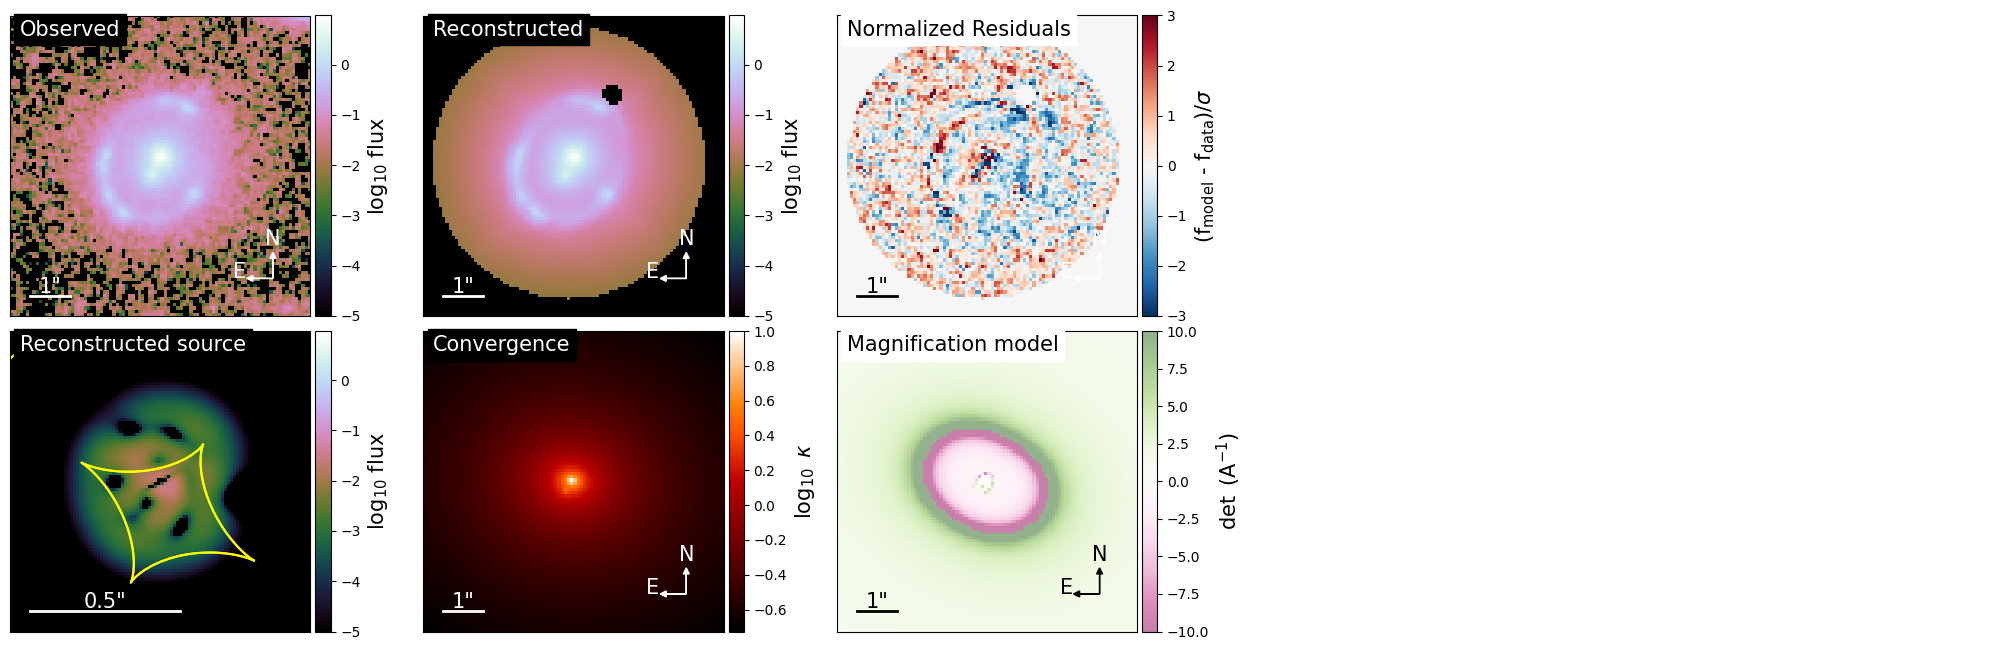

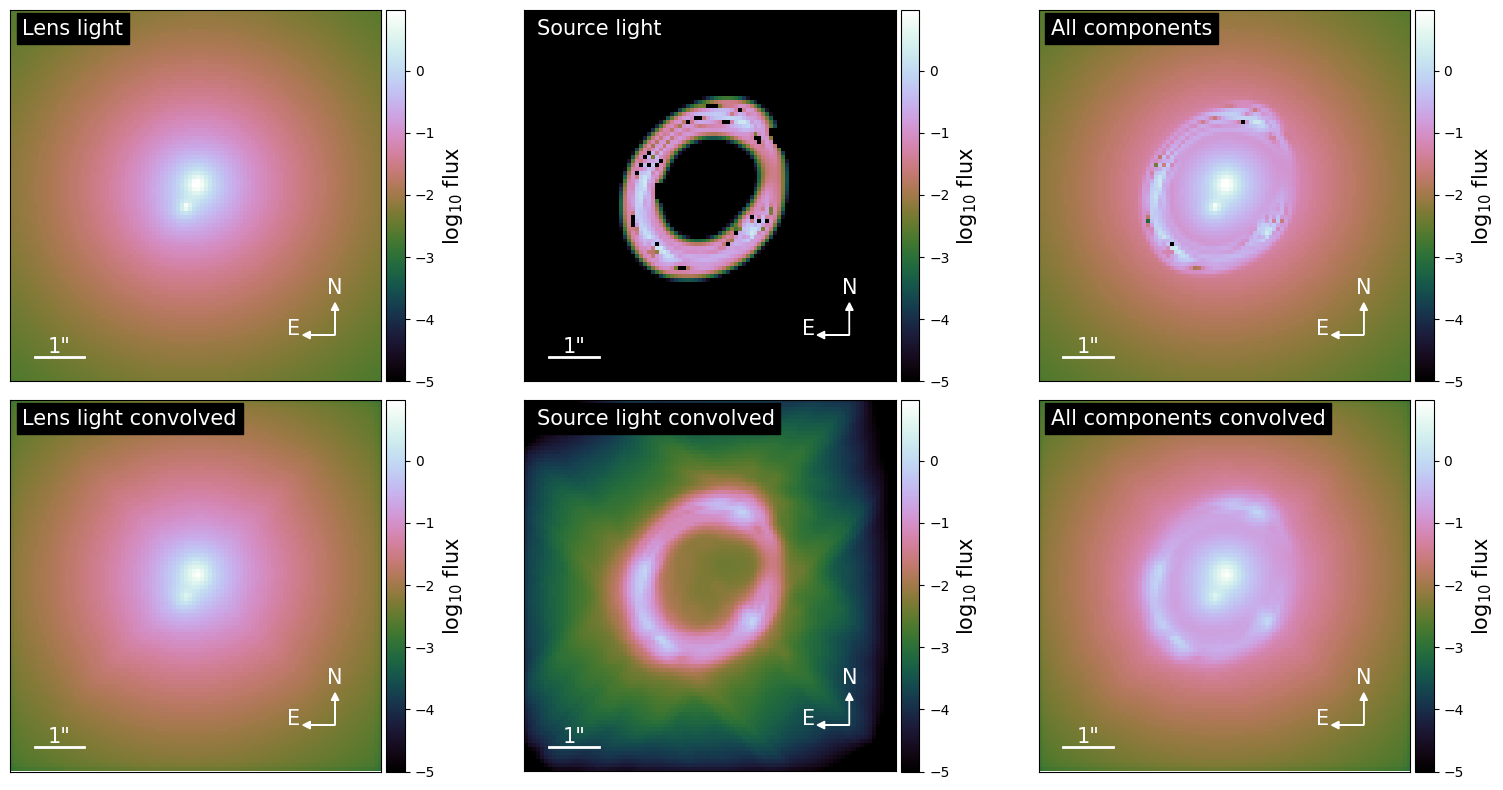

{'kwargs_lens': [{'theta_E': 1.2719482694045396, 'gamma': 1.8206033370630124, 'e1': 0.08313416278496612, 'e2': 0.030300287333879426, 'center_x': 0.11756322643667466, 'center_y': -0.055123932318686515}, {'gamma1': -0.0004132829125931166, 'gamma2': -0.07317227008224746, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.09821812787031482, 'e1': -0.0012743853402464379, 'e2': -0.09159193550524274, 'center_x': 0.27188819566132816, 'center_y': -0.31067337690244157}], 'kwargs_source': [{'amp': -309.12916370253345, 'R_sersic': 0.01417082863052686, 'n_sersic': 1.0, 'e1': 0.35353625011506645, 'e2': -0.49982580363349427, 'center_x': 0.14729711027596204, 'center_y': 0.04052926486991805}, {'amp': array([374.83715336, -30.83831501, -26.62636521,  10.43315517,
        69.09918854, -28.96564043,  42.01959798,  54.77330288,
        25.72263317,  18.27675827,  46.68016398, -17.59058981,
        64.84863848, -12.44589622,  79.61961398, -53.76543279,
       -10.67164471,  13.24027744,   5.95333105,  10.03389434,
     

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

## The MCMC Run

In [24]:
mcmc_backend = "./mcmc_backend.h5"

n_walkers = 100
n_step = 381
n_burn = 0

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": n_burn,
            "n_run": n_step,
            "n_walkers": n_walkers,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)

100%|██████████| 381/381 [1:09:47<00:00, 10.99s/it]


Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  0
Sampling iterations (in current run): 381
4192.605330944061 time taken for MCMC sampling


In [25]:
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()

 ## MCMC: Visualizing the Fitted Model

(900000, 26)
N_step: 9000, N_walkers: 100, N_params: 26


<ipython-input-26-dae8a93ba807>:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


theta_E_lens0 1.2755 ± 0.0649
gamma_lens0 1.9034 ± 0.0724
e1_lens0 0.0389 ± 0.0052
e2_lens0 -0.0027 ± 0.0044
center_x_lens0 0.1318 ± 0.0062
center_y_lens0 -0.0340 ± 0.0148
gamma1_lens1 -0.0251 ± 0.0047
gamma2_lens1 -0.0889 ± 0.0056
theta_E_lens2 0.0907 ± 0.0555
R_sersic_source_light0 0.0145 ± 0.0025
e1_source_light0 0.2414 ± 0.0222
e2_source_light0 -0.8393 ± 0.0165
center_x_source_light0 0.1373 ± 0.0037
center_y_source_light0 0.0236 ± 0.0042
beta_source_light1 0.0604 ± 0.0045
R_sersic_lens_light0 0.1279 ± 0.0026
e1_lens_light0 0.0036 ± 0.0062
e2_lens_light0 -0.0171 ± 0.0037
center_x_lens_light0 0.0598 ± 0.0008
center_y_lens_light0 0.1337 ± 0.0011
R_sersic_lens_light1 0.9192 ± 0.0181
R_sersic_lens_light2 0.2742 ± 0.0191
e1_lens_light2 0.0510 ± 0.0145
e2_lens_light2 -0.0583 ± 0.0205
center_x_lens_light2 0.2718 ± 0.0026
center_y_lens_light2 -0.3102 ± 0.0013


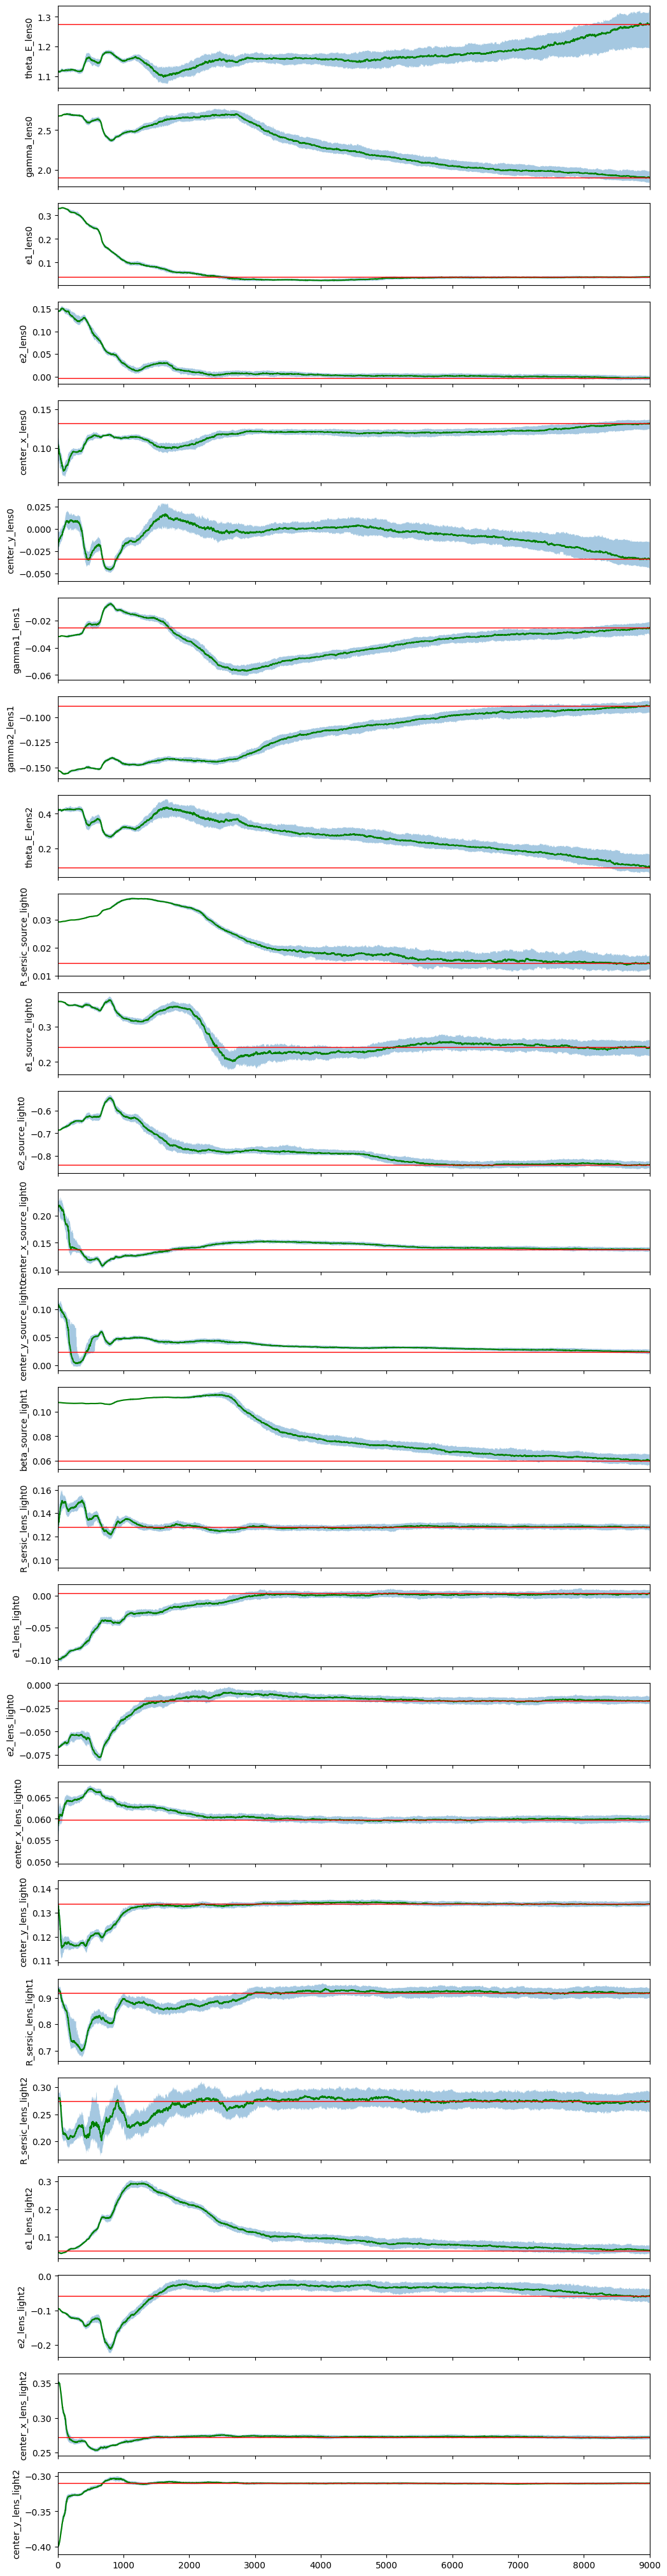

In [26]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

print(samples_mcmc.shape)

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]
    n_walkers = 100
    n_step = int(samples_mcmc.shape[0] / n_walkers)
    n_burn = 0

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )

        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

In [27]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 6000
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

Output hidden; open in https://colab.research.google.com to view.

-1.0302142468050643 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.030214246805063


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


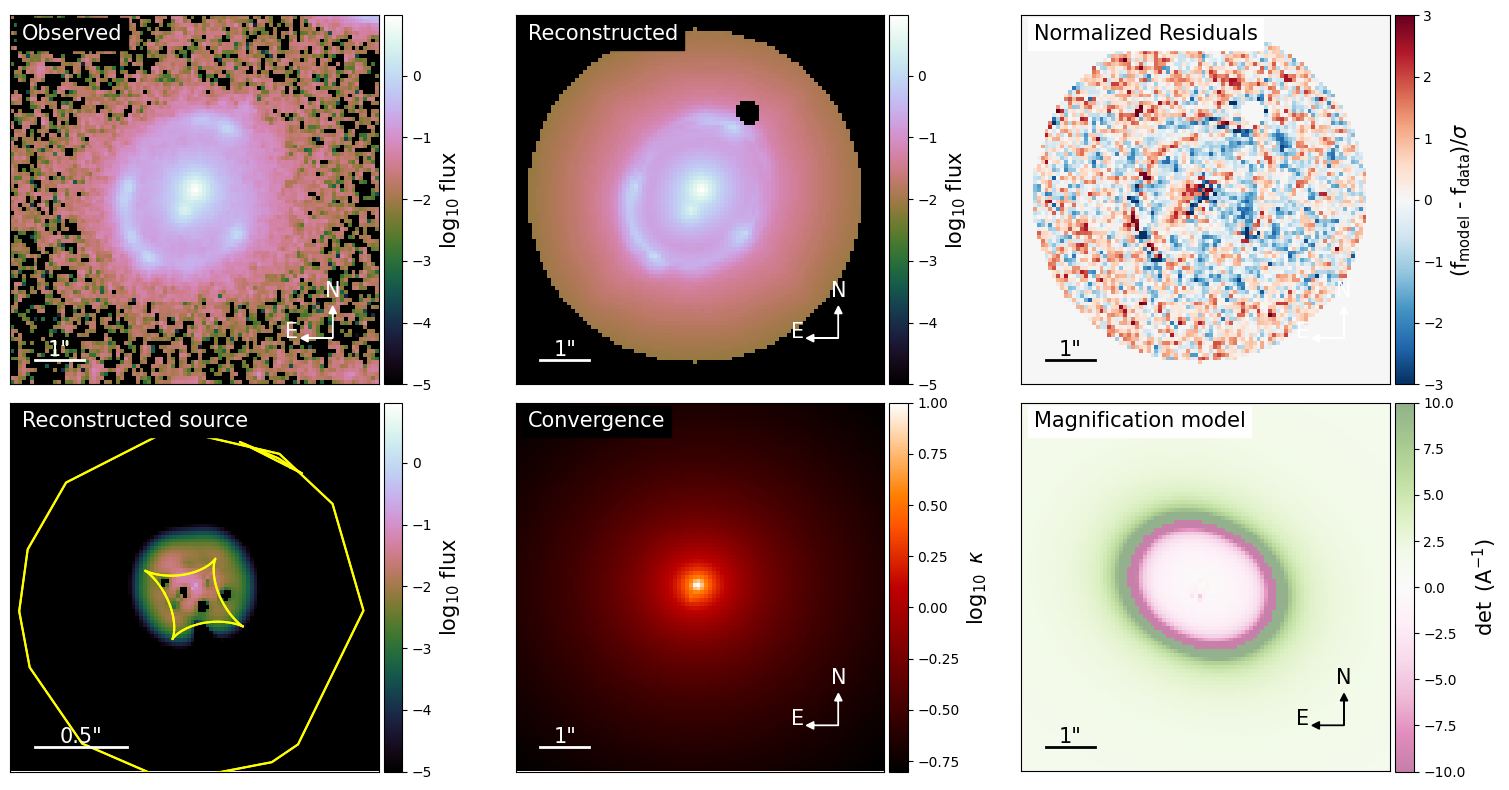

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: divide by zero encountered in log10
  np.log10(model),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


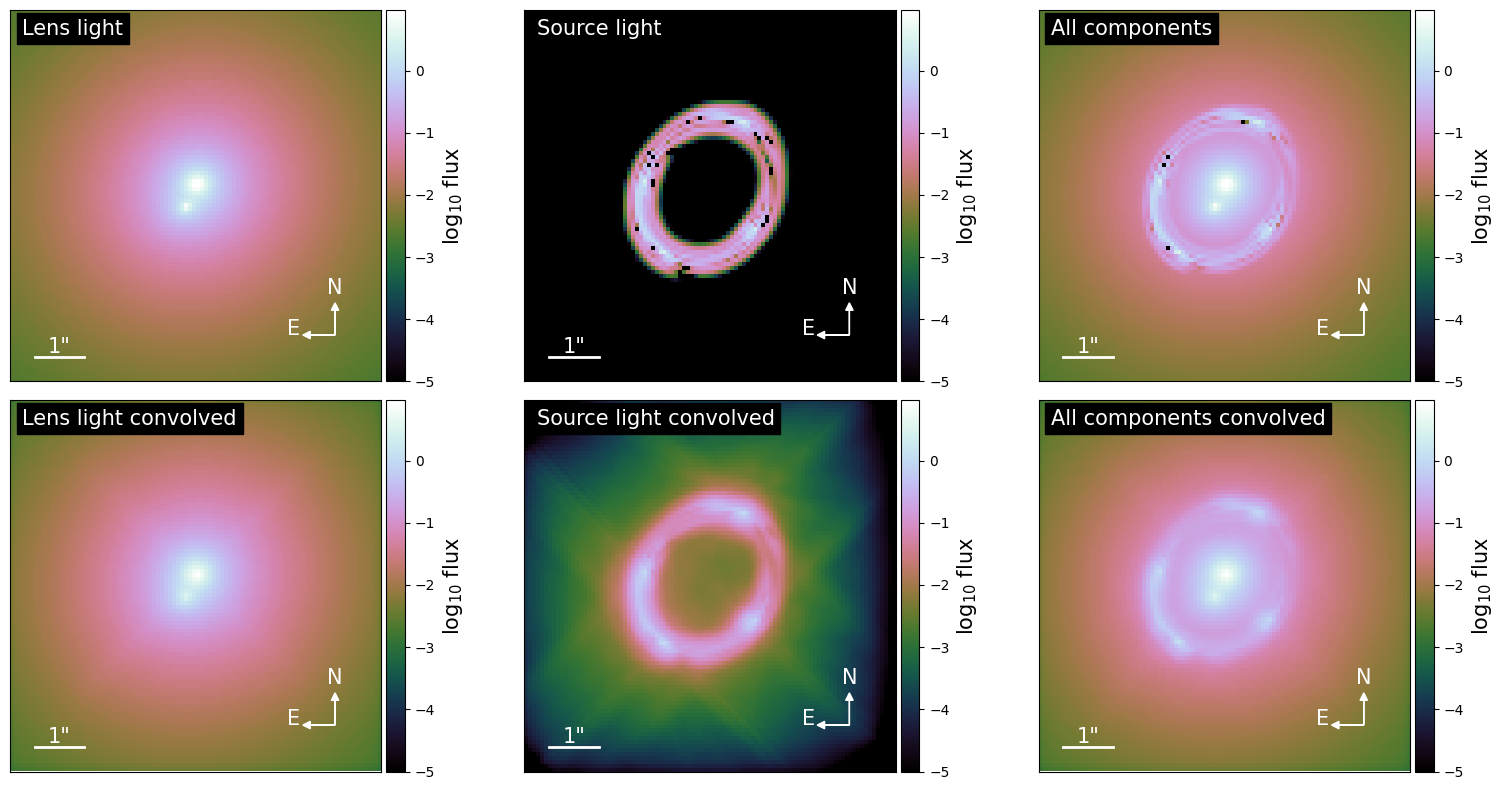

{'kwargs_lens': [{'theta_E': 1.3223883316684284, 'gamma': 1.9070106789882142, 'e1': 0.043180289815974576, 'e2': -0.006344046622468045, 'center_x': 0.13578916226527304, 'center_y': -0.04363946708282343}, {'gamma1': -0.022816808216358495, 'gamma2': -0.09066125525250583, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.05405971478065602, 'e1': 0.04721622108793801, 'e2': -0.06847387179079423, 'center_x': 0.27066754876643506, 'center_y': -0.31014531539696033}], 'kwargs_source': [{'amp': 112.3381373108769, 'R_sersic': 0.014892874476342507, 'n_sersic': 1.0, 'e1': 0.24896075331128553, 'e2': -0.8409786170825899, 'center_x': 0.13715103581645602, 'center_y': 0.022835286912355597}, {'amp': array([235.54625871,  28.57549156,  61.79600469,  33.67079863,
        66.56660591,  38.78890842,  20.55017624,  56.29740246,
        45.63051756, -15.16463361,  67.36664259,   4.82759173,
        58.64808332, -44.12946187,  17.03011886, -11.15311874,
        -6.37210875,  -4.24488101,   9.48797459,  -0.96085108,
        2

In [28]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result_mcmc)

In [30]:
result_mass_e1 = 0.043180289815974576
result_mass_e2 = -0.006344046622468045

result_light_e1 = 0.009650492242749293
result_light_e2 = -0.019462021086602804

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

mass_q: 0.9163625869577585,
light_q: 0.9574771147569107


In [31]:
multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = n_step  # can be not `None` for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result_mcmc, multi_band_list_out, kwargs_fixed_out]

output_path = "./DESIJ0201-2739_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)